In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import pickle
from sklearn.metrics import pairwise_distances, pairwise_kernels
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF
import networkx as nx
from tqdm.notebook import tqdm

import os
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning) 

import pandas as pd

import copy


import hypernetx as hnx

import pygenstability as pgs
from pygenstability import plotting

In [3]:
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

import scipy as sc
import scipy.sparse as sp

In [4]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [5]:
import random

random.seed(10)

In [6]:
# CHECKPOINT
edges_li = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_LI.pkl', 'rb'))
edges_lmi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_LMI.pkl', 'rb'))
edges_umi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_UMI.pkl', 'rb'))
edges_hi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_HI.pkl', 'rb'))

In [7]:
# CHECKPOINT
Adj2_li = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_li.pkl', 'rb'))
Adj2_lmi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_lmi.pkl', 'rb'))
Adj2_umi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_umi.pkl', 'rb'))
Adj2_hi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_hi.pkl', 'rb'))

In [8]:
# CHECKPOINT
Aw_li = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_li.pkl', 'rb'))
Aw_lmi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_lmi.pkl', 'rb'))
Aw_umi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_umi.pkl', 'rb'))
Aw_hi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj_hi.pkl', 'rb'))

In [9]:
def get_adjacency(H):
    
    """ Construct weighted adjacency matrix for HyperGraph H
    
    Arguments
    H : Hypernetx hypergraph object
    
    """

    incidence = H.incidence_matrix().toarray()
    
    # hyperedge adjacency matrix
    C = np.matmul(incidence.T,incidence)
    A = np.matmul(incidence,incidence.T)

    R = np.matmul(incidence, np.matmul(np.diag(np.diag(C)),incidence.T))

    # defining transition matrix
    adj = R - A
    np.fill_diagonal(adj,0)

    
    return adj

In [10]:
def compute_and_plot_eigenvector_hypergraph(g, pos, n_labels, weight=True):
    plt.figure(figsize=(10,6))
    g.edges(data=True)
    if weight==True:
        ec = nx.eigenvector_centrality(g, weight='weight')
    else:
        ec = nx.eigenvector_centrality(g)
    colors = list(ec.values())

    cmap=plt.cm.Blues
    vmin = min(colors)
    vmax = max(colors)
    nx.draw(g,pos=pos,node_size=800,node_color=colors,cmap=cmap,vmin=vmin, vmax=vmax)
    labels=nx.draw_networkx_labels(g,pos, labels=n_labels)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)
    plt.show()
    
    return ec

In [11]:
colors_SDG = {1:(229/255, 36/255, 59/255), 2:(221/255, 166/255, 58/255), 3:(76/255, 159/255, 56/255), 
              4: (197/255, 25/255, 45/255), 5:(1, 58/255, 33/255), 6: (38/255, 189/255, 226/255),
              7: (252/255,195/255, 11/255), 8: (162/255,25/255, 66/255), 9: (253/255, 105/255, 37/255),
              10: (221/255, 19/255, 103/255), 11: (253/255, 157/255, 36/255), 12:(191/255, 139/255, 46/255), 
              13: (63/255, 126/255, 68/255), 14: (10/255, 151/255, 217/255), 15: (86/255, 192/255, 43/255),
              16: (0, 104/255, 157/255), 17:(25/255, 72/255, 106/255) }

In [12]:
def plot_eig_centralities_reorg(G,  n_labels, name, shortname, colors=colors_SDG):
    degree = nx.eigenvector_centrality(G,  weight='weight')
    
    num = len(n_labels)
    
    values = list(degree.values())
    values_reorg = np.zeros(17)
    for j in range(num):
        sdg_ind = int(n_labels[j])
        values_reorg[sdg_ind-1] = values[j]
    
    
    
    labels = []
    for i in range(17):
        labels.append('SDG {}'.format(i+1))
        
    colors_list = []
    for i in range(17):
        colors_list.append(colors[i+1])
    
    width = 0.94
    plt.figure(figsize=(18,10))
    plt.tight_layout() 
    
    plt.bar(x=labels, height=values_reorg, width=width, color = colors_list, align='center')
    
    for i, (label, value) in enumerate(zip(labels, values_reorg)):
        img = mpimg.imread('/Users/saravallejomengod/MathsYear4/M4R/utils/SDG_icons/SDG-{}.png'.format(i+1))
        plt.imshow(img, extent=[i-width/2,i + width/2-0.01,  value - 0.052, value-0.002 ], aspect='auto', zorder=2)
        
    
    plt.ylim(0, max(values_reorg) * 1.05)
    plt.xlim(-0.5, len(values_reorg)-0.5 )
    
    plt.xticks(fontsize=13)
    
    plt.ylabel('Eigenvector centrality', x=-0.06, fontdict={'fontsize': 18})
    plt.title(name, y=1.05, fontdict={'fontsize': 46})
    
    plt.savefig('/Users/saravallejomengod/MathsYear4/M4R/utils/hx/{}_EC.png'.format(shortname), format='png', bbox_inches='tight')
    plt.show()

In [13]:
def plot_restricted_hypergraphs(H, name, shortname):
    plt.figure(figsize=(10,10))
    plt.tight_layout() 
    plt.title(name, fontdict={'fontsize': 30})
    
    hnx.draw(H, with_edge_labels=False, 
             node_labels_kwargs={'fontsize': 16}, pos=nx.circular_layout(H))
    plt.savefig('/Users/saravallejomengod/MathsYear4/M4R/utils/hx/{}_3.png'.format(shortname), format='png',bbox_inches='tight')
    
    

# Low Income

## Hypergraph

In [14]:
H_li = hnx.Hypergraph(edges_li)

## 3-way edges

In [25]:
Hli_restrict_edges3 = H_li.restrict_to_edges(list(e for e in edges_li if len(edges_li[e])==3))

# weighted adjacency matrix
graph_li3 = sp.csr_matrix(get_adjacency(Hli_restrict_edges3))

# construct network object for plotting
g_li3 = nx.Graph(graph_li3)
pos_li3 = nx.circular_layout(g_li3, scale=1)

# node names
Hli_restrict_edges3.nodes

EntitySet(_:Nodes,['3', '1', '14', '13', '6', '7', '17', '11', '12', '4', '5', '2'],{})

In [26]:
# create dictionary with node names
n_labels_li3 = {}
nodes_li3 = ['3', '1', '14', '13', '6', '7', '17', '11', '12', '4', '5', '2']
for i in range(len(nodes_li3)):
    n_labels_li3[i] = nodes_li3[i]

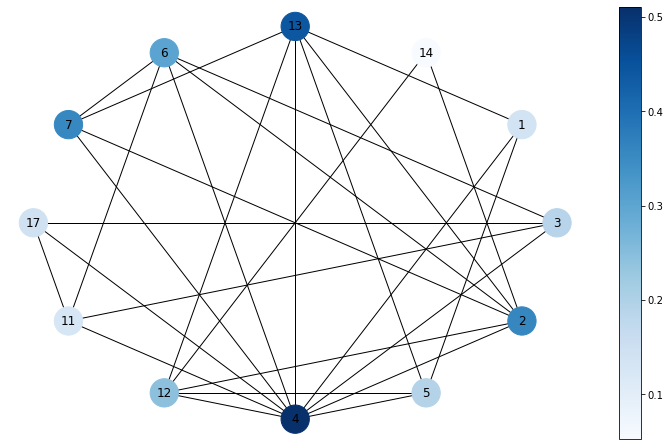

In [27]:
ec_li3 = compute_and_plot_eigenvector_hypergraph(g_li3, pos_li3, n_labels_li3)

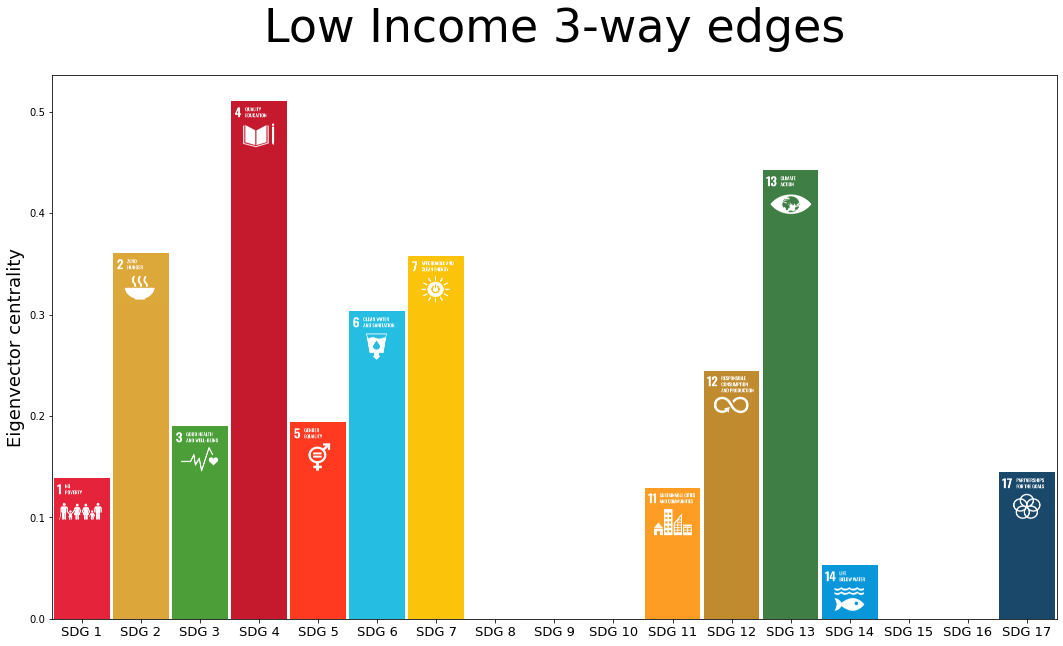

In [28]:
plot_eig_centralities_reorg(g_li3,  n_labels_li3, "Low Income 3-way edges", "LI3")

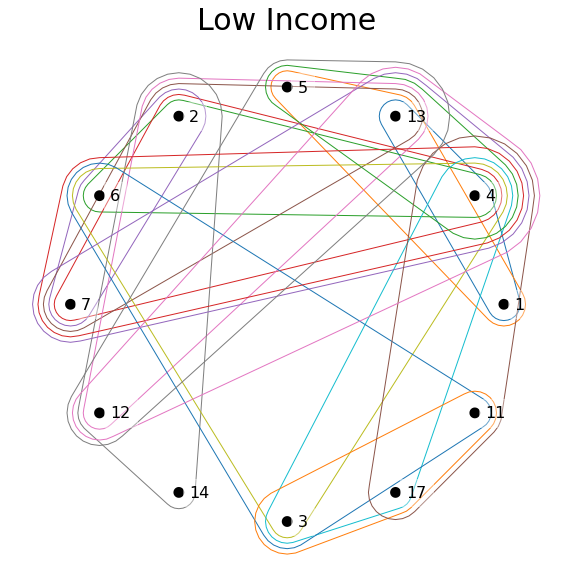

In [29]:
plot_restricted_hypergraphs(Hli_restrict_edges3, 'Low Income', 'LI')

In [86]:
Hli_restrict_edges3

Hypergraph({29: Entity(29,['1', '4', '13'],{}), 30: Entity(30,['1', '13', '5'],{}), 31: Entity(31,['6', '4', '2'],{}), 32: Entity(32,['7', '4', '2'],{}), 33: Entity(33,['7', '6', '2'],{}), 34: Entity(34,['7', '13', '2'],{}), 35: Entity(35,['12', '13', '2'],{}), 36: Entity(36,['12', '14', '2'],{}), 37: Entity(37,['6', '3', '4'],{}), 38: Entity(38,['3', '4', '17'],{}), 39: Entity(39,['6', '3', '11'],{}), 40: Entity(40,['3', '17', '11'],{}), 41: Entity(41,['4', '13', '5'],{}), 42: Entity(42,['7', '6', '4'],{}), 43: Entity(43,['7', '4', '13'],{}), 44: Entity(44,['4', '17', '11'],{}), 45: Entity(45,['12', '4', '13'],{}), 46: Entity(46,['12', '13', '5'],{})},name=_)

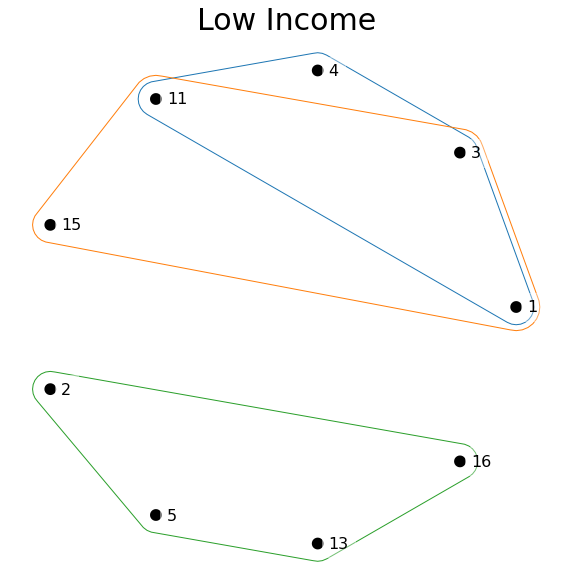

In [18]:
Hli_restrict_edges4 = H_li.restrict_to_edges(list(e for e in edges_li if len(edges_li[e])==4))
plot_restricted_hypergraphs(Hli_restrict_edges4, 'Low Income', 'LI4')

# Lower Middle Income

## Hypergraph

In [16]:
H_lmi = hnx.Hypergraph(edges_lmi)

# 3-way edges

In [27]:
Hlmi_restrict_edges3 = H_lmi.restrict_to_edges(list(e for e in edges_lmi if len(edges_lmi[e])==3))

# weighted adjacency matrix
graph_lmi3 = sp.csr_matrix(get_adjacency(Hlmi_restrict_edges3))

# construct network object for plotting
g_lmi3 = nx.Graph(graph_lmi3)
pos_lmi3 = nx.circular_layout(g_lmi3, scale=1)

# node names
Hlmi_restrict_edges3.nodes

EntitySet(_:Nodes,['16', '8', '12', '1', '17', '13', '6', '7', '2', '3', '11', '14', '10', '9', '5'],{})

In [28]:
# create dictionary with node names
n_labels_lmi3 = {}
nodes_lmi3 = ['16', '8', '12', '1', '17', '13', '6', '7', '2', '3', '11', '14', '10', '9', '5']
for i in range(len(nodes_lmi3)):
    n_labels_lmi3[i] = nodes_lmi3[i]

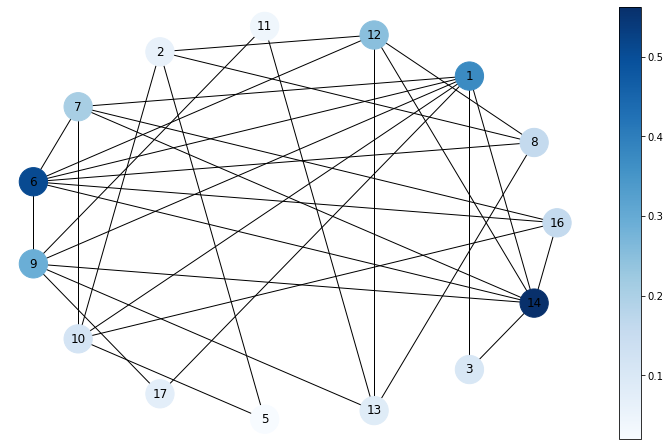

In [25]:
ec_lmi3 = compute_and_plot_eigenvector_hypergraph(g_lmi3, pos_lmi3, n_labels_lmi3)

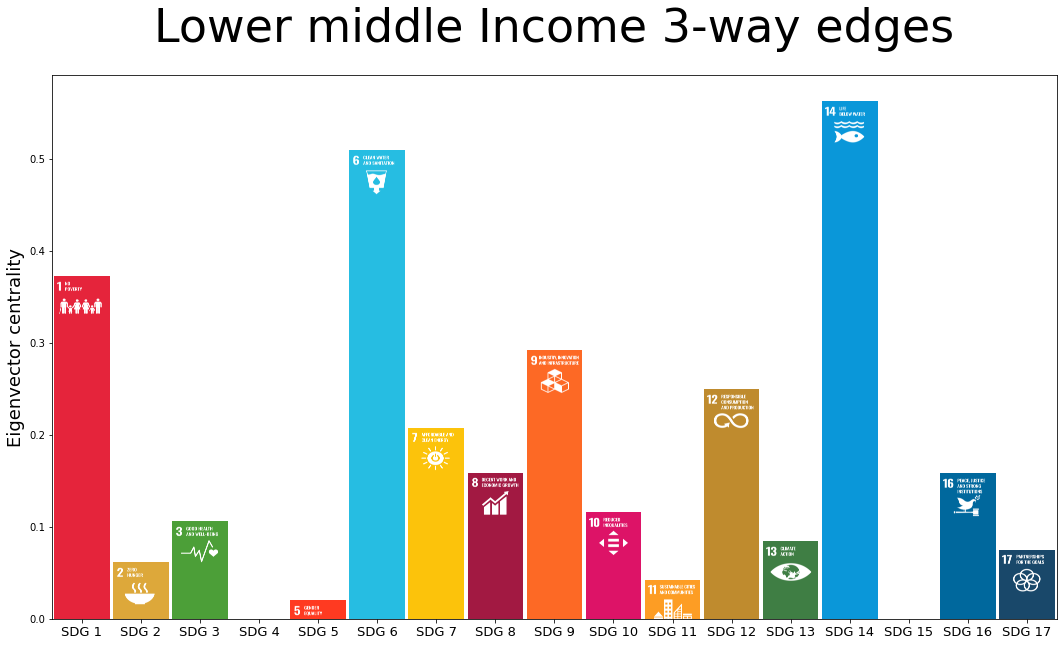

In [31]:
plot_eig_centralities_reorg(g_lmi3,  n_labels_lmi3, "Lower middle Income 3-way edges", "LMI3")

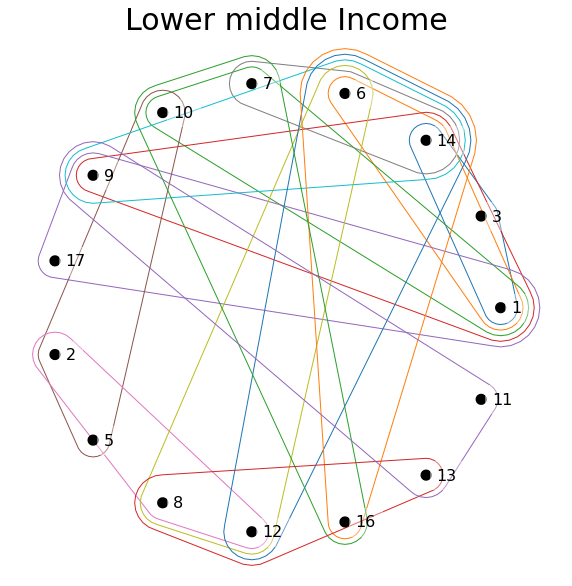

In [62]:
plot_restricted_hypergraphs(Hlmi_restrict_edges3, 'Lower middle Income', 'LMI')

In [84]:
Hlmi_restrict_edges3

Hypergraph({45: Entity(45,['3', '14', '1'],{}), 46: Entity(46,['14', '6', '1'],{}), 47: Entity(47,['7', '1', '10'],{}), 48: Entity(48,['14', '1', '9'],{}), 49: Entity(49,['1', '17', '9'],{}), 50: Entity(50,['2', '10', '5'],{}), 51: Entity(51,['8', '2', '12'],{}), 52: Entity(52,['7', '6', '14'],{}), 53: Entity(53,['8', '6', '12'],{}), 54: Entity(54,['14', '6', '9'],{}), 55: Entity(55,['12', '6', '14'],{}), 56: Entity(56,['14', '6', '16'],{}), 57: Entity(57,['7', '10', '16'],{}), 58: Entity(58,['8', '13', '12'],{}), 59: Entity(59,['11', '13', '9'],{})},name=_)

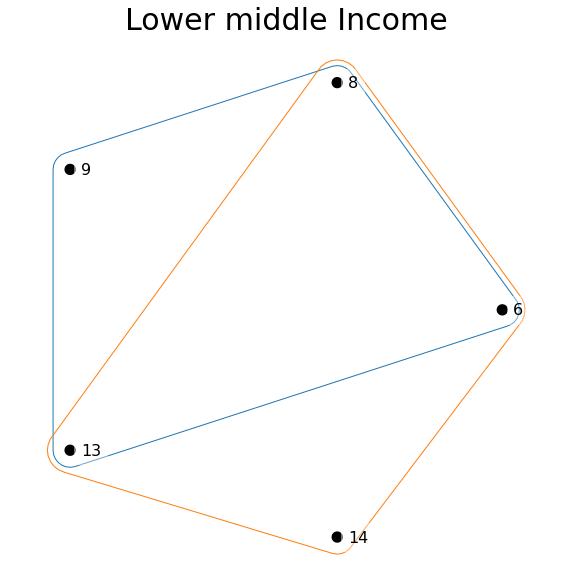

In [19]:
Hlmi_restrict_edges4 = H_lmi.restrict_to_edges(list(e for e in edges_lmi if len(edges_lmi[e])==4))
plot_restricted_hypergraphs(Hlmi_restrict_edges4, 'Lower middle Income', 'LMI4')

# Upper Middle Income

## Hypergraph

In [20]:
H_umi = hnx.Hypergraph(edges_umi)

## 3-way edges

In [38]:
Humi_restrict_edges3 = H_umi.restrict_to_edges(list(e for e in edges_umi if len(edges_umi[e])==3))

# weighted adjacency matrix
graph_umi3 = sp.csr_matrix(get_adjacency(Humi_restrict_edges3))

# construct network object for plotting
g_umi3 = nx.Graph(graph_umi3)
pos_umi3 = nx.circular_layout(g_umi3, scale=1)

# node names
Humi_restrict_edges3.nodes

EntitySet(_:Nodes,['16', '8', '12', '1', '15', '13', '10', '7', '3', '11', '14', '4', '2', '9', '5'],{})

In [39]:
# create dictionary with node names
n_labels_umi3 = {}
nodes_umi3 = ['16', '8', '12', '1', '15', '13', '10', '7', '3', '11', '14', '4', '2', '9', '5']
for i in range(len(nodes_umi3)):
    n_labels_umi3[i] = nodes_umi3[i]

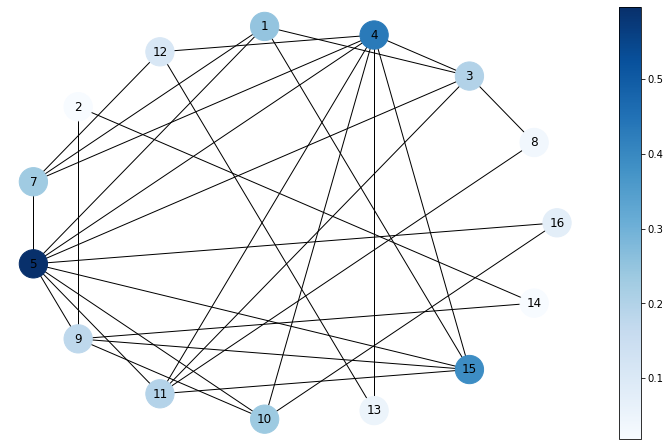

In [30]:
ec_umi3 = compute_and_plot_eigenvector_hypergraph(g_umi3, pos_umi3, n_labels_umi3)

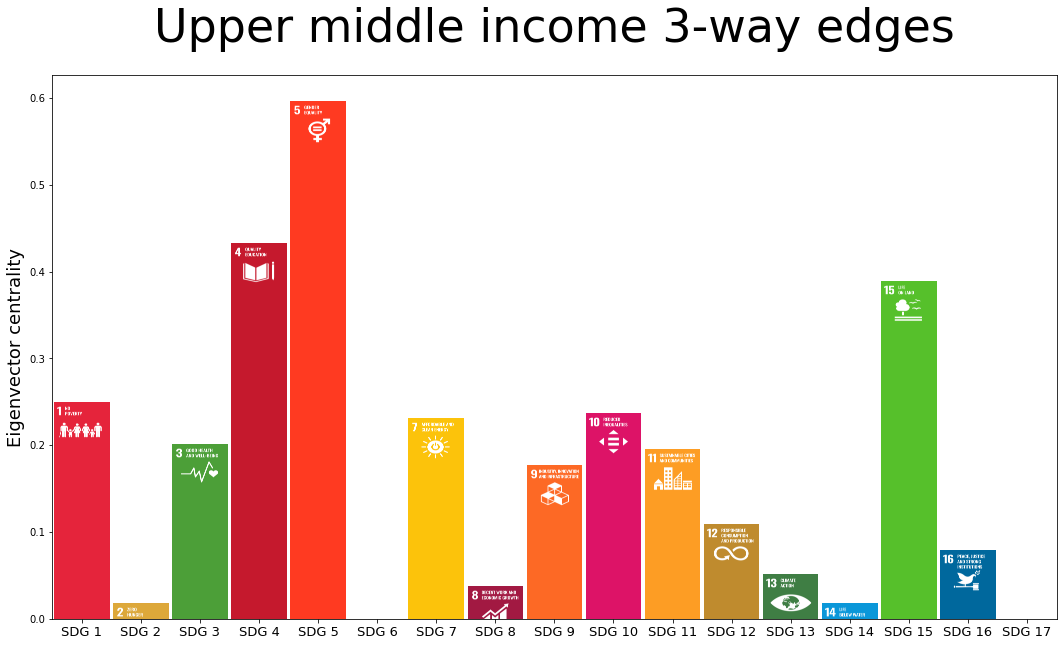

In [40]:
plot_eig_centralities_reorg(g_umi3,  n_labels_umi3, "Upper middle income 3-way edges", "UMI3")

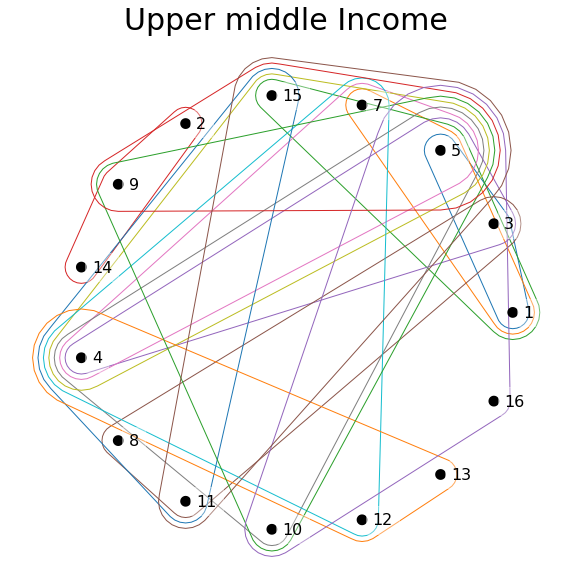

In [63]:
plot_restricted_hypergraphs(Humi_restrict_edges3, 'Upper middle Income', 'UMI')

In [82]:
Humi_restrict_edges3

Hypergraph({54: Entity(54,['3', '1', '5'],{}), 55: Entity(55,['7', '1', '5'],{}), 56: Entity(56,['1', '15', '5'],{}), 57: Entity(57,['14', '2', '9'],{}), 58: Entity(58,['3', '4', '5'],{}), 59: Entity(59,['8', '3', '11'],{}), 60: Entity(60,['7', '4', '5'],{}), 61: Entity(61,['4', '10', '5'],{}), 62: Entity(62,['15', '4', '5'],{}), 63: Entity(63,['7', '4', '12'],{}), 64: Entity(64,['15', '4', '11'],{}), 65: Entity(65,['12', '4', '13'],{}), 66: Entity(66,['10', '9', '5'],{}), 67: Entity(67,['15', '9', '5'],{}), 68: Entity(68,['10', '16', '5'],{}), 69: Entity(69,['15', '11', '5'],{})},name=_)

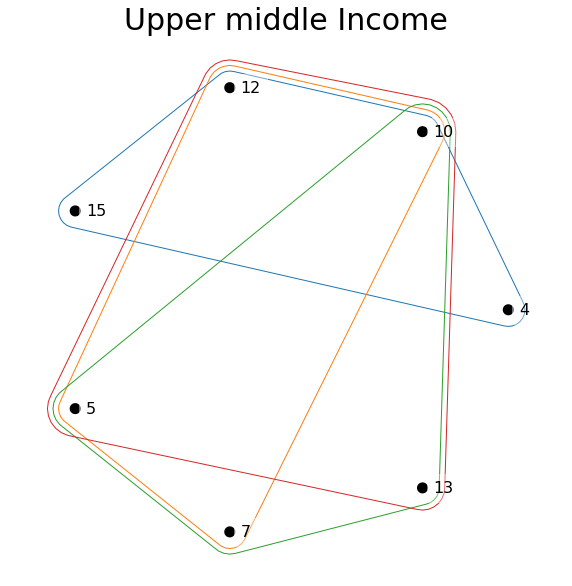

In [21]:
Humi_restrict_edges4 = H_umi.restrict_to_edges(list(e for e in edges_umi if len(edges_umi[e])==4))
plot_restricted_hypergraphs(Humi_restrict_edges4, 'Upper middle Income', 'UMI4')

# High Income
## Hypergraph

In [22]:
H_hi = hnx.Hypergraph(edges_hi)

## 3-way edges

In [24]:
Hhi_restrict_edges3 = H_hi.restrict_to_edges(list(e for e in edges_hi if len(edges_hi[e])==3))

# weighted adjacency matrix
graph_hi3 = sp.csr_matrix(get_adjacency(Hhi_restrict_edges3))

# construct network object for plotting
g_hi3 = nx.Graph(graph_hi3)
pos_hi3 = nx.circular_layout(g_hi3, scale=1)

# node names
Hhi_restrict_edges3.nodes

EntitySet(_:Nodes,['3', '15', '14', '13', '6'],{})

In [30]:
# create dictionary with node names
n_labels_hi3 = {}
nodes_hi3 = ['3', '15', '14', '13', '6']
for i in range(len(nodes_hi3)):
    n_labels_hi3[i] = nodes_hi3[i]

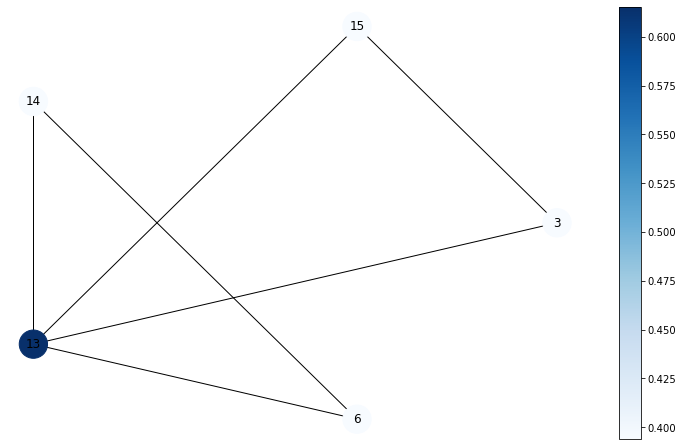

In [31]:
ec_hi3 = compute_and_plot_eigenvector_hypergraph(g_hi3, pos_hi3, n_labels_hi3)

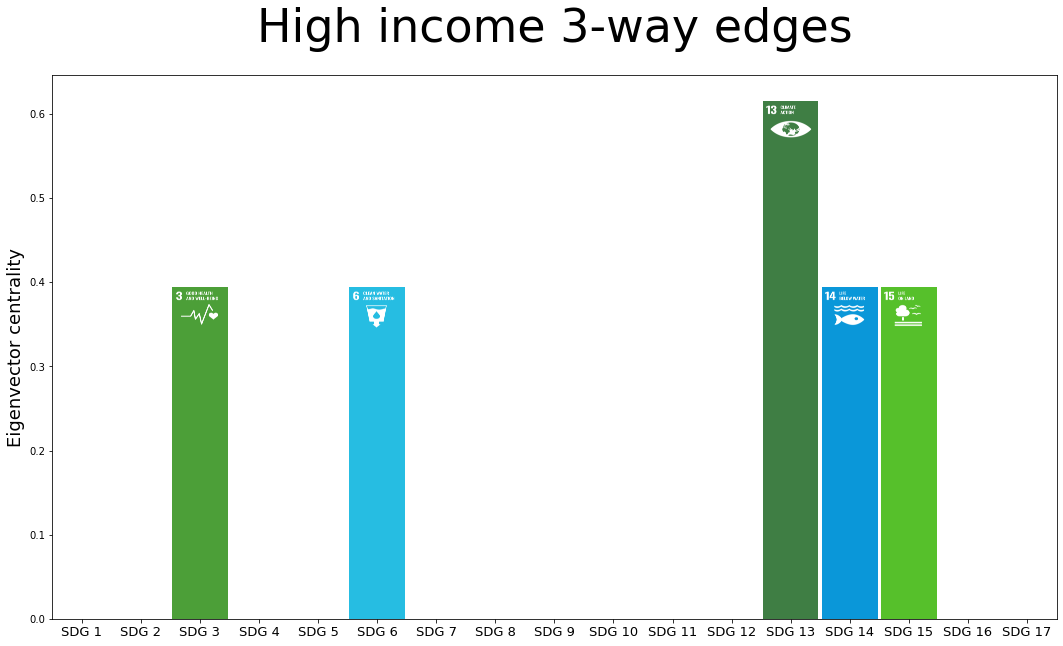

In [32]:
plot_eig_centralities_reorg(g_hi3,  n_labels_hi3, "High income 3-way edges", "HI3")

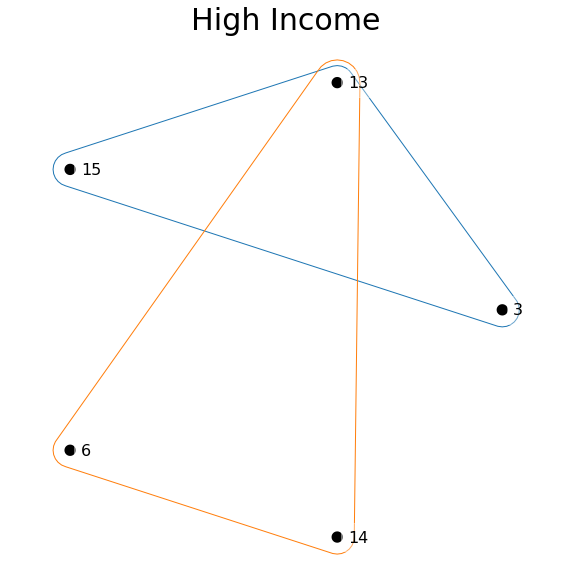

In [33]:
plot_restricted_hypergraphs(Hhi_restrict_edges3, 'High Income', 'HI')